<div style="text-align: center; margin: 20px; font-family: Georgia, serif; font-size: 32px; color: #333; background-color: #f0f0f0; padding: 20px; border-radius: 10px; font-weight: bold;">
    <span style="color: #2c3e50;">Imputation via Regression for Missing Data</span>
    
    

<div style="font-family: Tahoma; font-size: 18px; color: #000; background-color: #f9f9f9; padding: 15px; border-radius: 8px;">
    <h2 style="color: #2980b9; text">The Problem</h2>
    <p>Real-world datasets often contain missing values from measurement errors, data-entry mistakes, equipment failures, or survey non-response. If ignored or handled poorly, missingness can bias estimates, reduce statistical power, and undermine reproducibility — so analysts should assess the missingness mechanism and apply suitable remedies (deletion, imputation, or model-based methods) and report their approach transparently.</p>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 18px; color: #333;'>
    <h2 style='color: #238;'>The Solution</h2>
    <p style='font-family: Tahoma; line-height: 1.4;'>Imputation replaces missing values so analyses can use more of the available data while avoiding case deletion. Choosing an appropriate imputation technique matters because different methods make different assumptions and affect variability and bias.</p>
    <ul style='font-family: Tahoma; line-height: 1.6;'>
        <li><strong>Mean / median imputation:</strong> Replace missing entries with the variable mean or median; simple but can underestimate variability.</li>
        <li><strong>Regression imputation:</strong> Predict missing values using other features to preserve relationships; depends on correct model form.</li>
        <li><strong>Hot-deck / k-NN:</strong> Fill from similar records to maintain realistic distributions.</li>
        <li><strong>Multiple imputation:</strong> Create several plausible completed datasets and combine results to reflect imputation uncertainty.</li>
    </ul>
    <p style='font-family: Tahoma; line-height: 1.4;'>Best practice is to diagnose the missingness mechanism, validate imputed values with diagnostics, and report the chosen method and its assumptions transparently.</p>
    <p>In this analysis, we will explore median and regression-based imputation to compare how they handle missing data and the implications for downstream results.</p>
</div>

<strong>Importing essentials and setting theme</strong>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
sns.set_theme('notebook', palette='colorblind')
%matplotlib inline

In [2]:
# add hover effect to pandas dataframes

def enable_table_hover():
    display(HTML("""
    <style>
        table.dataframe tbody tr:hover {
            background-color: #f5f5f5 !important;
        }
    </style>
    """))

enable_table_hover()

## <strong>Data preprocessing and Imputation</strong>

In [3]:
credit_df = pd.read_csv('creditcard_default.csv')
credit_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [4]:
# getting df info
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    The credit card default dataset contains information on credit card clients in Taiwan, including demographic factors, credit data, payment history, and whether they defaulted on their payment. The dataset has 30,000 entries and 24 attributes (+1 index column). Let us now see how many missing values does this dataset has.
<div>

In [5]:
print(credit_df.isnull().sum())
display(HTML(f"""<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
             The dataset has no missing values. This is not common in real-world datasets, so it is not useful for our analysis. 
             Hence, we will introduce some missing values artificially for demonstration purposes.
             We will randomly set 5% of the values in the 'AGE' and 'BILL_AMT' column to NaN. </div>"""))

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [6]:
# function to introduce missing values
def introduce_nan(df, column, fraction, random_state):
    np.random.seed(random_state)
    n_missing = int(fraction * len(df))
    missing_indices = np.random.choice(df.index, n_missing, replace=False)
    df.loc[missing_indices, column] = np.nan

### <strong>Imputation Strategy 1: Median Imputation</strong>

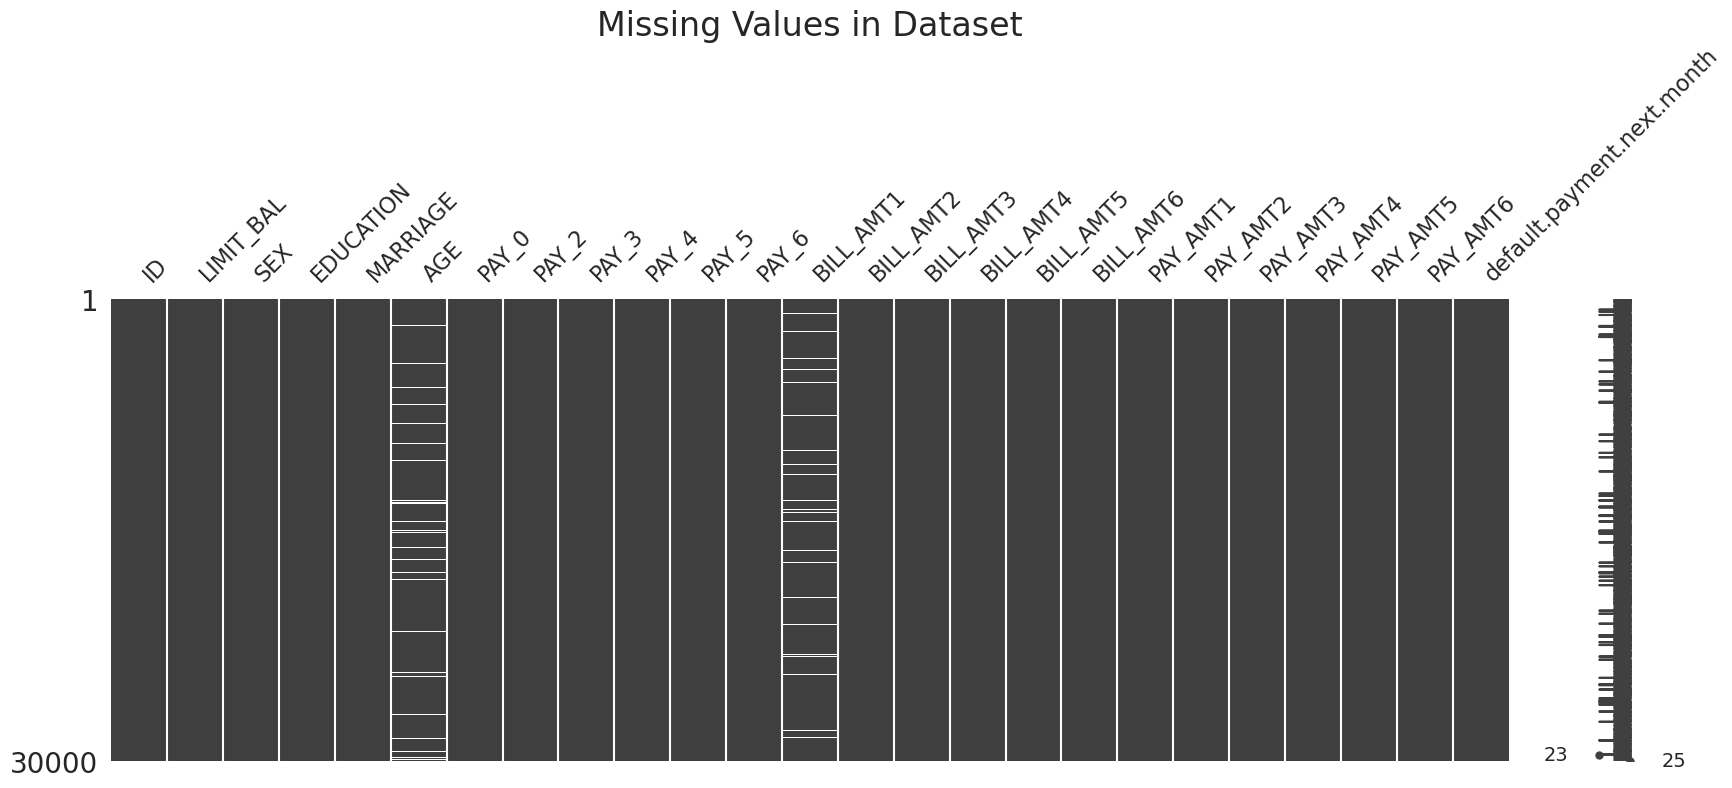

In [7]:
# making a copy of df to work with
dataset_A = credit_df.copy()

# introducing 5% missing values in 'AGE' and 'BILL_AMT1'
introduce_nan(dataset_A, 'AGE', 0.05, random_state=123)
introduce_nan(dataset_A, 'BILL_AMT1', 0.05, random_state=456)
columns_with_nan = ['AGE', 'BILL_AMT1']

# visualising nan values
import missingno as mno
mno.matrix(dataset_A, figsize=(20, 6))
plt.title('Missing Values in Dataset', fontsize=24)
plt.show()

In [8]:
# imputing with median
for col in columns_with_nan:
    dataset_A[col].fillna(dataset_A[col].median(), inplace=True)

dataset_A.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 18px; color: #000;'>
    <h3 style='color: #123;'><strong>Why median and not mean?</strong></h3>
    <p style='font-family: Tahoma; line-height: 1.4;'>Median imputation is often preferred over mean imputation because it is more robust to outliers and skewed distributions. The median represents the middle value of a dataset, so it is less influenced by extreme values that can distort the mean. This makes median imputation a better choice when the data contains outliers or is not normally distributed, as it helps preserve the central tendency of the data without being affected by anomalies.</p>
</div>

### <strong> Imputation Strategy 2: Imputation via Linear Regression </strong>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 18px; color: #000;'>
    <h3 style='color: #123;'><strong>Why regression-based imputation?</strong></h3>
    <p style='font-family: Tahoma; line-height: 1.4;'>A natural question that one might ask is, <em>Why do we need regression-based imputation when we can already fill missing data with measures of central tendency (mean or median)?</em> It is much easier to do and it gets the job done.</p>
    <p style='font-family: Tahoma; line-height: 1.4;'>Apparently, it doesn't get the job done. When we replace the missing data with some common value (mean or median), we might under(over)estimate the value of that variable for that particular datatype. This adds bias to our estimation.</p>
    <p style='font-family: Tahoma; line-height: 1.4;'>Regression-based imputation, on the other hand, uses the relationships between variables to predict missing values. By leveraging the information from other related variables, regression-based imputation can provide more accurate and contextually relevant estimates for the missing data. This method helps to preserve the underlying patterns and correlations in the dataset, leading to more reliable analyses and insights.</p>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <h3 style='color: #123;'>Approach for Regression-based Imputation</h3>
    <p style='font-family: Tahoma; line-height: 1.4;'>
        The approach for regression-based imputation involves the following steps:
    </p>
    <ol style='font-family: Tahoma; line-height: 1.6;'>
        <li><strong>Identify the target variable:</strong> Determine which variable has missing values that need to be imputed. In this case, it is the 'AGE' column.</li>
        <li><strong>Select predictor variables:</strong> Choose other variables in the dataset that are likely to be correlated with the target variable. These variables will be used to predict the missing values.</li>
        <li><strong>Split the dataset:</strong> Divide the dataset into two parts: one with complete cases (where the target variable is not missing) and another with missing values in the target variable.</li>
        <li><strong>Train a regression model:</strong> Use the complete cases to train a regression model that predicts the target variable based on the selected predictor variables.</li>
        <li><strong>Predict missing values:</strong> Apply the trained regression model to the subset of the dataset with missing values in the target variable to predict and fill those missing values.</li>
        <li><strong>Combine the datasets:</strong> Merge the imputed values back into the original dataset, replacing the missing values in the target variable.</li>
    </ol>
    <p style='font-family: Tahoma; line-height: 1.4;'>
        By following this approach, we can effectively impute missing values in the 'AGE' column using regression-based imputation, leveraging the relationships between variables to provide more accurate estimates.
    </p>
</div>

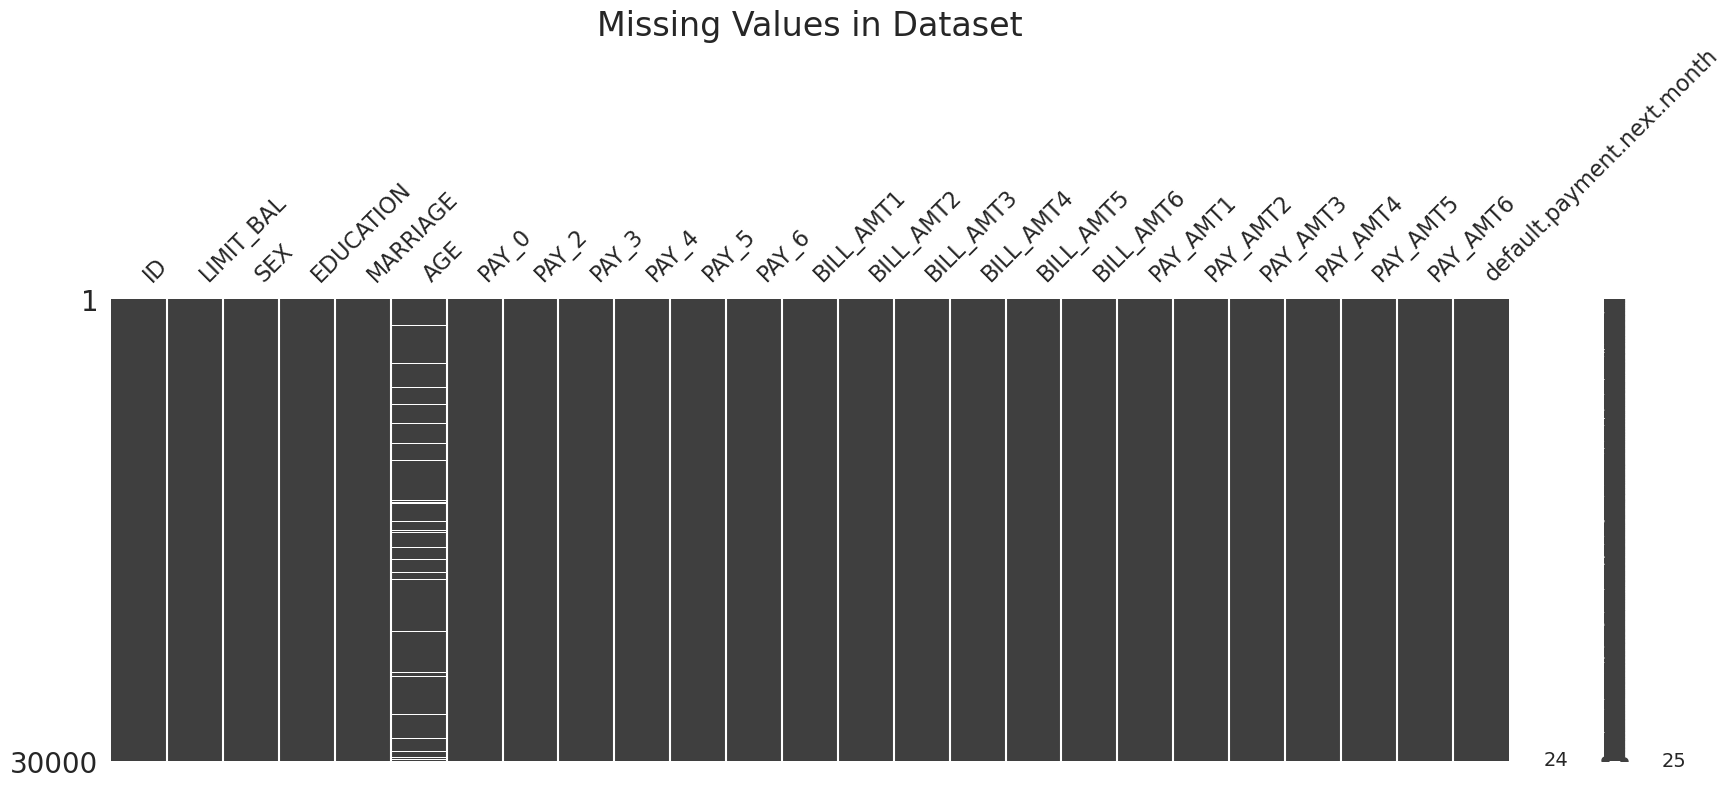

In [9]:
df = credit_df.copy()

# introducing 5% missing values in 'AGE' column
introduce_nan(df, 'AGE', 0.05, random_state=123)

# visualising nan values
mno.matrix(df, figsize=(20, 6))
plt.title('Missing Values in Dataset', fontsize=24)
plt.show()


In [10]:
# creating dataset_B for regression-based imputation
dataset_B = df.copy()
dataset_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         28500 non-null  float64
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [11]:
# making a copy of dataset_B to train regression model
df_reg = dataset_B.copy()
# dropping rows with nan values in 'AGE' column for training regression model
df_reg.dropna(inplace=True)
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28500 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          28500 non-null  int64  
 1   LIMIT_BAL                   28500 non-null  float64
 2   SEX                         28500 non-null  int64  
 3   EDUCATION                   28500 non-null  int64  
 4   MARRIAGE                    28500 non-null  int64  
 5   AGE                         28500 non-null  float64
 6   PAY_0                       28500 non-null  int64  
 7   PAY_2                       28500 non-null  int64  
 8   PAY_3                       28500 non-null  int64  
 9   PAY_4                       28500 non-null  int64  
 10  PAY_5                       28500 non-null  int64  
 11  PAY_6                       28500 non-null  int64  
 12  BILL_AMT1                   28500 non-null  float64
 13  BILL_AMT2                   28500 no

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <p>Now that we have filled the missing values in the copy of the dataframe, we can use it to train the regression model and predict the missing values in the original dataframe.</p>
    <p>We will use the 'AGE' as the target variable and the other columns as the features. We will use the LinearRegression model 
    from the sklearn library to train the model and predict the missing values.</p>
</div>

In [12]:
# training linear regression model on df_reg
from sklearn.linear_model import LinearRegression

# training the model for 'AGE'
X_age = df_reg.drop(columns=['AGE'])
y_age = df_reg['AGE']
lr_age = LinearRegression()
lr_age.fit(X_age, y_age)


print("Model trained successfully.")

Model trained successfully.


<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <p>The models have been trained for 'AGE'. We can now use the model to predict the missing values in the original dataframe.</p>
    <p>We will use the <code>predict()</code> method of the LinearRegression model to predict the missing values in the 'AGE' column of the original dataframe. We will then fill the missing values in the original dataframe with the predicted values.</p>
</div>

In [13]:
def impute_with_regression(df, column, model, feature_columns):
    missing_indices = df[df[column].isnull()].index
    if not missing_indices.empty:
        X_missing = df.loc[missing_indices, feature_columns]
        valid_mask = X_missing.notnull().all(axis=1)
        valid_indices = missing_indices[valid_mask]
        if len(valid_indices) > 0:
            X_valid = df.loc[valid_indices, feature_columns]
            predicted_values = model.predict(X_valid)
            df.loc[valid_indices, column] = predicted_values
            return len(valid_indices)
        return 0
    return 0

# Use the same columns as used in model training
n_age = impute_with_regression(dataset_B, 'AGE', lr_age, X_age.columns)
print(f"Imputed {n_age} missing AGE values using regression")


for col in columns_with_nan:
    n_remaining = dataset_B[col].isnull().sum()
    if n_remaining > 0:
        print(f"Filling {n_remaining} remaining {col} missing values with median...")
        dataset_B[col].fillna(dataset_B[col].median(), inplace=True)

print("\nFinal missing values check:")
print(dataset_B.isnull().sum())
dataset_B.shape

Imputed 1500 missing AGE values using regression

Final missing values check:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


(30000, 25)

In [14]:
display(HTML(f"""
<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 15px; color: #000;'>
    We have imputed <strong>{n_age}</strong> missing values in the <strong>'AGE'</strong> column using regression. Any remaining missing <strong>'AGE'</strong> values (if present) were filled with the median as a fallback. 
    <br><br>
    Note: there were no missing values in <strong>'BILL_AMT1'</strong>.
</div>
"""))

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <h3 style='color: #123;'><strong>Assumptions of linear regression imputation</strong></h3>
    <ul style='color:#000; font-family: Tahoma; line-height: 1.6;'>
        <li>Linear regression imputation assumes that the relationship between the target variable (the variable with missing values) and the predictor variables (the other variables in the dataset) is linear. This means that the change in the target variable is proportional to the change in the predictor variables.</li>
        <li>Additionally, linear regression imputation assumes that the predictor variables are not highly correlated with each other (no multicollinearity) and that the residuals (the differences between the observed and predicted values) are normally distributed and homoscedastic (constant variance).</li>
        <li>If these assumptions are violated, the imputed values may be biased or inaccurate. Therefore, it is important to assess the suitability of linear regression imputation for the specific dataset and consider alternative imputation methods if necessary.</li>
    </ul>
</div>

### <strong>Imputation strategy 3: Imputation by Decision Tree regression</strong>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <h3 style='color: #123;'><strong>Decision Tree regression</strong></h3>
    <p>Decision Tree regression is a non-linear regression technique that can be used to impute missing values in a dataset. It works by creating a tree-like model that splits the data into subsets based on the values of the predictor variables. The model then predicts the target variable (the variable with missing values) based on the values of the predictor variables in each subset.</p>
    <p>Decision Tree regression can handle non-linear relationships between the target variable and the predictor variables, making it a powerful tool for imputation. It can also handle categorical variables and missing values in the predictor variables.</p>
    <p>In this analysis, we will use Decision Tree regression to impute the missing values in the 'AGE' column of the original dataframe. We will use the same approach as we did for linear regression imputation, but we will use the DecisionTreeRegressor model from the sklearn library to train the model and predict the missing values.</p>
</div>

In [15]:
# creating Dataset C for non-linear imputation
dataset_C = df.copy()
dataset_C.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         28500 non-null  float64
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <p>Split dataset_C into two subsets: df1(rows without missing AGE) and df2(rows with missing AGE). Train the DecisionTreeRegressor on df1, then predict AGE for df2 assign the predicted values to df2['AGE']. Finally concatenate df1 and df2 to recreate dataset_C with imputed ages.</p>


In [16]:
# preparing data for 'AGE' imputation

# separate data into two groups -- where 'AGE' is known (df1) and where 'AGE' is unknown (df2)
df1 = dataset_C[dataset_C['AGE'].notnull()]
df2 = dataset_C[dataset_C['AGE'].isnull()]


In [17]:
# training DecisionTreeRegressor on df1, treating 'AGE' as target variable
from sklearn.tree import DecisionTreeRegressor
X = df1.drop(columns=['AGE'])
y = df1['AGE']
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X, y)

DecisionTreeRegressor(random_state=42)

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 18px; color: #000;'>
    <p>Now that the Decision Tree regression model has been trained, we can use it to predict the missing values in the part where 'AGE' is missing in df2. We will use the <code>predict()</code> method of the DecisionTreeRegressor model to predict the missing values in the 'AGE' column of the df2. We will then concatanate df1 and df2 to make the complete dataset.</p>
</div>

In [18]:
# predict missing AGE values in dataset_C using the trained Decision Tree model
n_age_dt = impute_with_regression(dataset_C, 'AGE', tree, df1.drop(columns=['AGE']).columns)

print(f"Imputed {n_age_dt} missing AGE values using Decision Tree regression")
print("\nFinal missing values check:")
print(dataset_C.isnull().sum())


Imputed 1500 missing AGE values using Decision Tree regression

Final missing values check:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


## <strong>Model Training and Evaluation</strong>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <p>We have seen so far different imputation techniques to handle missing data in a dataset. Now, we will evaluate the performance of these imputation techniques by training a machine learning model on the imputed datasets and comparing their performance.</p>
    <p>We will also compare the performance of the models trained on the imputed datasets with a model trained on the subset of the dataset where rows with missing values were simply dropped. This will inform us whether doing imputation is worth the effort compared to simply dropping the datapoints with missing values which is the easiest thing we can do.</p>
    <em style='color: #e22b2bff; font-size:18px; font-family;Georgia;'>Let's find out!!</em>

### <strong>Generating dataset_D by dropping rows with missing values</strong>

In [19]:
# generating dataset_D by dropping rows with missing values
dataset_D = df.copy()
dataset_D = dataset_D.dropna().reset_index(drop=True)
dataset_D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28500 entries, 0 to 28499
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          28500 non-null  int64  
 1   LIMIT_BAL                   28500 non-null  float64
 2   SEX                         28500 non-null  int64  
 3   EDUCATION                   28500 non-null  int64  
 4   MARRIAGE                    28500 non-null  int64  
 5   AGE                         28500 non-null  float64
 6   PAY_0                       28500 non-null  int64  
 7   PAY_2                       28500 non-null  int64  
 8   PAY_3                       28500 non-null  int64  
 9   PAY_4                       28500 non-null  int64  
 10  PAY_5                       28500 non-null  int64  
 11  PAY_6                       28500 non-null  int64  
 12  BILL_AMT1                   28500 non-null  float64
 13  BILL_AMT2                   285

### <strong>Training Logistic Regression models on all datasets and comparing their performance</strong>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <p>Now that we have all the required datasets -- A, B, C, and D -- we can proceed to train machine learning models on each of these datasets and evaluate their performance. This will allow us to compare the effectiveness of the different imputation techniques (median imputation, regression-based imputation using linear regression, regression-based imputation using decision tree regression) against the baseline approach of dropping rows with missing values.</p>
    <h3 style='color: #123;'><strong>Building pipeline to train and test for classification</strong></h3>
    <p style='font-family: Tahoma; line-height: 1.4;'>Our aim is to understand which imputation technique (or dropping the rows) yields the best performance when training a machine learning model. We will use a classification model to predict whether a credit card client will default on their payment based on the features in the dataset. We will evaluate the performance of the models using accuracy, precision, recall, and F1-score as metrics.</p>
    <p style='font-family: Tahoma; line-height: 1.4;'>To achieve this, we will build a pipeline that includes data preprocessing steps (such as scaling), model training, and evaluation. We will use the same classification algorithm for all datasets to ensure a fair comparison of the imputation techniques.</p>
    <p style='font-family: Tahoma; line-height: 1.4;'>Therefore, the next steps will involve:</p>
    <ol style='font-family: Tahoma; line-height: 1.6;'>
        <li>Defining the features and target variable for classification.</li>
        <li>Splitting each dataset into training and testing sets.</li>
        <li>Building a machine learning pipeline that includes data scaling and a classification model.</li>
        <li>Training the model on the training set of each dataset.</li>
        <li>Evaluating the model on the testing set of each dataset using accuracy, precision, recall, and F1-score.</li>
        <li>Comparing the performance metrics across the different datasets to determine which imputation technique is most effective.</li>
    </ol>
    </ul>
</div>

In [20]:
# defining features and target variable
feature_cols = [col for col in df.columns if col != 'default.payment.next.month']
target_col = 'default.payment.next.month'

# splitting datasets into X and y

# splitting dataset_A
X_A = dataset_A[feature_cols]
y_A = dataset_A[target_col]

# splitting dataset_B
X_B = dataset_B[feature_cols]
y_B = dataset_B[target_col]

# splitting dataset_C
X_C = dataset_C[feature_cols]
y_C = dataset_C[target_col]

# splitting dataset_D
X_D = dataset_D[feature_cols]
y_D = dataset_D[target_col]

In [31]:
# building pipeline for model training and evaluation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# function to train and evaluate model
def train_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42))
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # build classification report as DataFrame and render as HTML with orange hover effect
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report_dict).T.round(3)
    html_table = df_report.to_html(classes='report-table', border=0)
    css = """
    <style>
      .report-table {width: 100%; font-family: Arial, sans-serif;}
      .report-table thead th {background-color: #f53939ff; padding: 8px; text-align: left; border-bottom: 1px solid #ddd;}
      .report-table tbody td {padding: 8px; border-bottom: 1px solid #f1f1f1;}
      .report-table tbody tr:hover {background-color: #fff !important;} /* light orange hover */
      .report-table caption {font-weight: bold; margin-bottom: 6px; color: #333; font-size: 18px; text-align: centre;}
    </style>
    """
    display(HTML(css + html_table))
    
    return accuracy, precision, recall, f1



In [32]:
# training and evaluating on dataset_A
print("Evaluation of Dataset A (Median Imputation):")

accuracy_A, precision_A, recall_A, f1_A = train_evaluate_model(X_A, y_A)

Evaluation of Dataset A (Median Imputation):


,precision,recall,f1-score,support
0,0.820,0.971,0.889,4687.000
1,0.699,0.238,0.355,1313.000
accuracy,0.811,0.811,0.811,0.811
macro avg,0.759,0.605,0.622,6000.000
weighted avg,0.793,0.811,0.772,6000.000


In [33]:
# training and evaluating on dataset_B
print("Evaluation of Dataset B (Regression Imputation):")

accuracy_B, precision_B, recall_B, f1_B = train_evaluate_model(X_B, y_B)

Evaluation of Dataset B (Regression Imputation):


,precision,recall,f1-score,support
0,0.819,0.971,0.889,4687.00
1,0.696,0.235,0.352,1313.00
accuracy,0.810,0.810,0.810,0.81
macro avg,0.758,0.603,0.620,6000.00
weighted avg,0.792,0.810,0.771,6000.00


In [34]:
# training and evaluating on dataset_C
print("Evaluation of Dataset C (Decision Tree Imputation):")

accuracy_C, precision_C, recall_C, f1_C = train_evaluate_model(X_C, y_C)

Evaluation of Dataset C (Decision Tree Imputation):


,precision,recall,f1-score,support
0,0.820,0.971,0.889,4687.00
1,0.695,0.238,0.354,1313.00
accuracy,0.810,0.810,0.810,0.81
macro avg,0.757,0.604,0.621,6000.00
weighted avg,0.792,0.810,0.772,6000.00


In [35]:
# training and evaluating on dataset_D
print("Evaluation of Dataset D (Dropping Missing Values):")

accuracy_D, precision_D, recall_D, f1_D = train_evaluate_model(X_D, y_D)

Evaluation of Dataset D (Dropping Missing Values):


,precision,recall,f1-score,support
0,0.823,0.977,0.893,4477.000
1,0.731,0.231,0.352,1223.000
accuracy,0.817,0.817,0.817,0.817
macro avg,0.777,0.604,0.622,5700.000
weighted avg,0.803,0.817,0.777,5700.000


## <strong>Conclusion</strong>

In [26]:
# create a summary dataframe of evaluation metrics for all datasets
metrics_df = pd.DataFrame({
    'Dataset': ['A (Median)', 'B (LinearReg)', 'C (DecisionTree)', 'D (Dropped)'],
    'Accuracy': [accuracy_A, accuracy_B, accuracy_C, accuracy_D],
    'Precision': [precision_A, precision_B, precision_C, precision_D],
    'Recall': [recall_A, recall_B, recall_C, recall_D],
    'F1-score': [f1_A, f1_B, f1_C, f1_D]
}).set_index('Dataset')

# round for readability and display
metrics_df = metrics_df.round(3)
display(metrics_df)

,Accuracy,Precision,Recall,F1-score
Dataset,,,,
A (Median),0.811,0.699,0.238,0.355
B (LinearReg),0.810,0.696,0.235,0.352
C (DecisionTree),0.810,0.695,0.238,0.354
D (Dropped),0.817,0.731,0.231,0.352


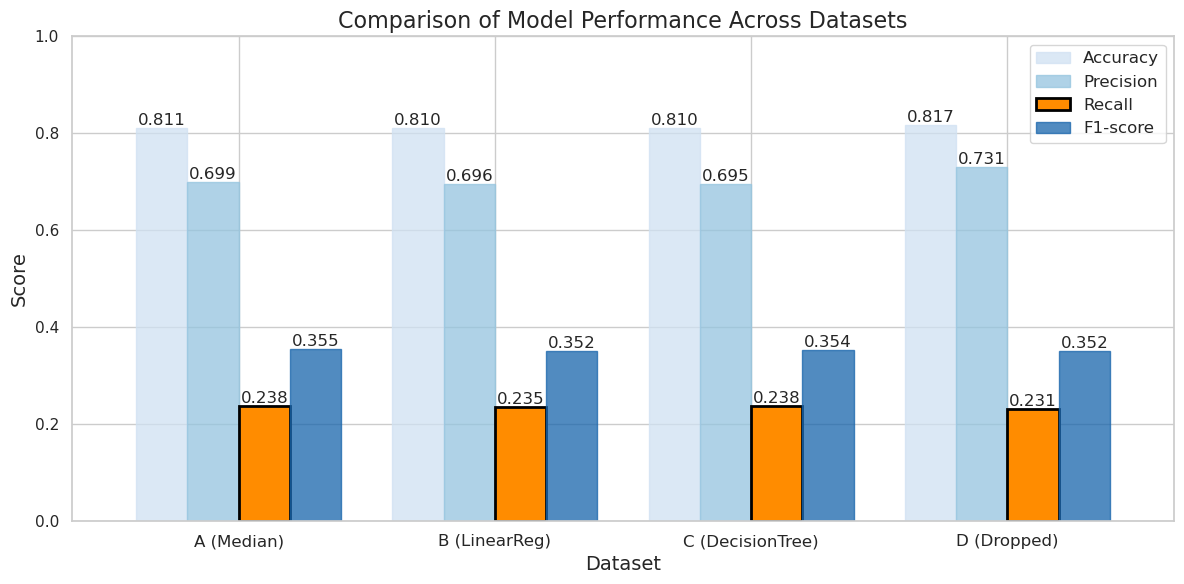

In [27]:
sns.set_theme(context='notebook', style='whitegrid')
ax = metrics_df.plot(
    kind='bar',
    figsize=(12, 6),
    edgecolor='black',
    width=0.8
)
# Get a blue palette with enough unique shades for your number of metrics minus Recall
num_metrics = len(ax.containers)
blues = sns.color_palette("Blues", n_colors=num_metrics)

# For example, if Recall is the third metric (index 2)
recall_idx = 2

# Assign blue shades to non-Recall bars, orange to Recall
for idx, container in enumerate(ax.containers):
    if idx == recall_idx:
        # Recall bars
        for bar in container:
            bar.set_color('darkorange')
            bar.set_edgecolor('black')
            bar.set_linewidth(2)
    else:
        # Use a different blue shade from the palette
        shade = blues[idx]
        for bar in container:
            bar.set_color(shade)
            bar.set_alpha(0.75)  # Optional: slight transparency

# Show values on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=12, label_type='edge')

ax.set_title('Comparison of Model Performance Across Datasets', fontsize=16)
ax.set_xlabel('Dataset', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_ylim(0, 1)
ax.set_xticklabels(metrics_df.index, rotation=0, fontsize=12)

# Set legend labels corresponding to your metrics
ax.legend([container.get_label() for container in ax.containers], fontsize=12)

plt.tight_layout()
plt.show()


### <strong>Efficacy of Imputation Techniques</strong>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <h3 style='color: #123;'><strong>Summary of Findings</strong></h3>
    <p style='font-family: Tahoma; line-height: 1.4;'>In the plot shown above we notice that the values of different metric for different models are nearly the same. However, one thing stands out -- <b>each of them have a low <em>Recall</em> value</b>. This indicates that the models are struggling to correctly identify the minority class (default cases) in the dataset and it is not related to the imputation technique. The model itself is having difficulty in generalizing its learning to predict minority classes accurately in unseen data.</p>
    <strong>Why other metrics are high but Recall is low?</strong>
    <p style='font-family: Tahoma; line-height: 1.4;'>
        Accuracy, Precision, and F1-score can be misleading in imbalanced datasets. In this case, the dataset has a significant class imbalance, with a majority of non-default cases compared to default cases. As a result, the model can achieve high accuracy and precision by simply predicting the majority class most of the time, while failing to identify the minority class effectively. This leads to a low Recall, as the model misses many of the actual default cases.
    </p>
    </div>

<strong>Class imbalance in the dataset</strong>

In [28]:
value_counts = credit_df['default.payment.next.month'].value_counts().sort_index()
# setting value counts dataframe
value_counts_df = pd.DataFrame({
    'Class': value_counts.index,
    'Count': value_counts.values,
    'Percentage': (value_counts.values / len(credit_df) * 100).round(2)
})

# making HTML table 
html_table = value_counts_df.to_html(index=False, classes='value-counts-table', border=0)
css = """
<style>
  .value-counts-table {
    width: 50%; 
    font-family: Arial, sans-serif; 
    margin: 20px auto;
    border-collapse: collapse;
  }
  .value-counts-table thead th {
    background-color: #2980b9; 
    color: white;
    padding: 12px; 
    text-align: center; 
    border-bottom: 2px solid #1a5490;
  }
  .value-counts-table tbody td {
    padding: 10px; 
    border-bottom: 1px solid #f1f1f1;
    text-align: center;
  }
  .value-counts-table tbody tr:hover {
    background-color: #ffd8b3 !important;
  }
</style>
"""
display(HTML(css + html_table))

Class,Count,Percentage
0,23364,77.88
1,6636,22.12


<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <h3 style='color: #123;'><strong>Why Model D performed poorly?</strong></h3>
    <ul>Model D might perform poorly compared to the other models for several reasons:</br>
        <br><li><strong>Loss of Information:</strong> By dropping rows with missing values, Model D loses potentially valuable information that could have contributed to better predictions. This reduction in data can lead to a less representative training set, which can negatively impact the model's ability to generalize to unseen data.</li></br>
        <li><strong>Bias Introduction:</strong> If the missingness in the data is not completely random, dropping rows with missing values can introduce bias into the dataset. This bias can skew the model's understanding of the underlying patterns in the data, leading to poorer performance.</li>
    </ul>
    </div>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <h3 style='color: #123;'><strong>Which regression model is better?</strong></h3>
    <p>Both linear regression and decision tree regression have their strengths and weaknesses when it comes to imputation. The choice between the two depends on the specific characteristics of the dataset and the nature of the missingness.</p>
    <p>Linear regression is a good choice when the relationship between the target variable and the predictor variables is linear and the assumptions of linear regression are met. It is also computationally efficient and easy to interpret. However, it may not perform well if the relationship is non-linear or if there are complex interactions between variables.</p>
    <p>Decision tree regression, on the other hand, can capture non-linear relationships and interactions between variables more effectively. It is also robust to outliers and can handle both numerical and categorical variables. However, decision trees can be prone to overfitting, especially if the tree is allowed to grow too deep.</p>
</div>

<div style='background-color: #f9f9f9; padding: 20px; border-radius: 10px; font-family: Tahoma; font-size: 16px; color: #000;'>
    <h3 style='color: #123;'><strong>Best strategy to handle missing values</strong></h3>
    <p>We can summarize the findings from our analysis as follows:</p>
        <ul style='font-family: Tahoma; line-height: 1.6;'>
            <li>Performance is similar across all missing data strategies. None offer a substantial gain in recall or F1-score, indicating that the model primarily struggles to identify positive/true cases, regardless of imputation method.</li>
            <li><b>Imputation (preferably regression-based, if a strong predictor exists) is generally recommended over listwise deletion</b>, as it preserves dataset size and can avoid potential bias.</li>
            <li>If the imputed feature shows a simple (linear) relationship with predictors, linear regression imputation is sufficient and computationally efficient. If you suspect complex non-linear patterns, decision trees can be more robust, but in your case, there's little to gain.</li>
            <li>The overarching issue appears to be low recall and F1, so it's crucial to further explore feature engineering or class-rebalancing strategies to improve identification of minority classes.</li>
        </ul>